Running grid:   0%|          | 0/101 [00:00<?, ?it/s]

Running grid: 100%|██████████| 101/101 [00:07<00:00, 14.40it/s]


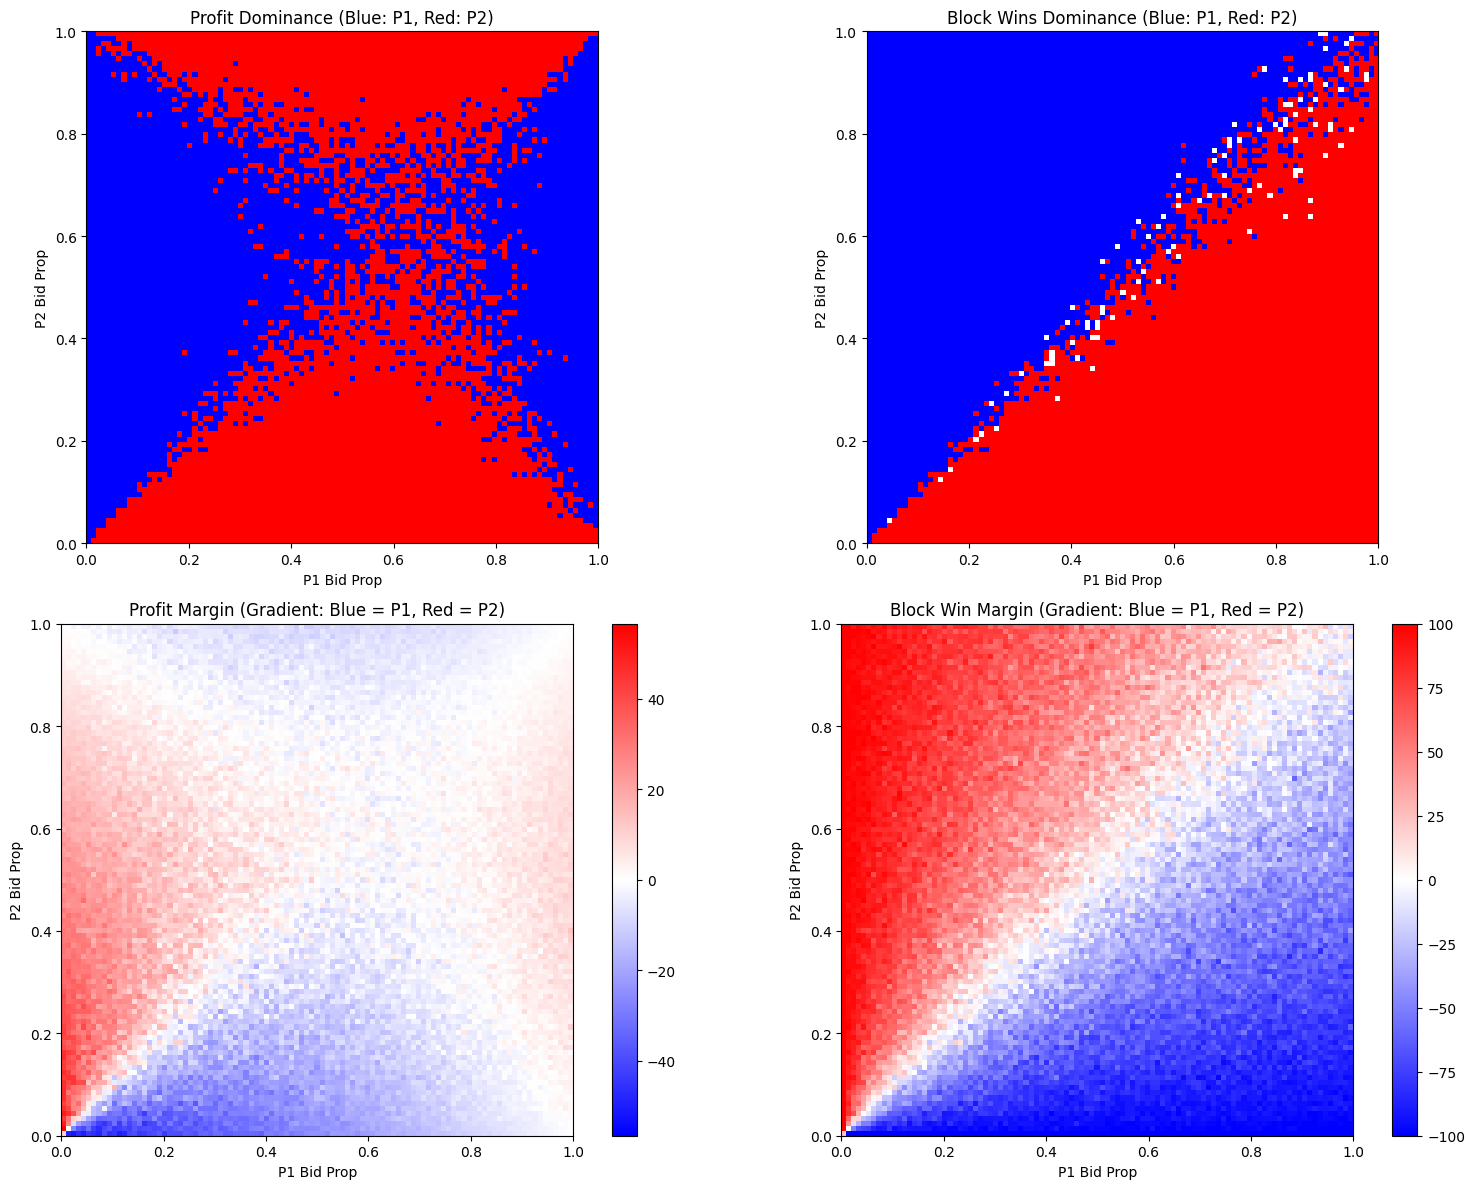

In [16]:
# Unreactive 1v1s : Bid Prop Analysis

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.colors import ListedColormap, BoundaryNorm

from auction import Auction
from player import GaussianRangePlayer, GaussianRangePlayer2

# Simulation settings
bid_props = np.round(np.arange(0, 1.01, 0.01), 2)
n_rounds = 100
speed_range = (0.0, 0.9)
cutoff_time_range = (1.0, 1.0)  # Speed ignored

# Initialize result matrices
profit_matrix = np.zeros((len(bid_props), len(bid_props)))     # 0, 1, 2
win_matrix = np.zeros((len(bid_props), len(bid_props)))        # 0, 1, 2
profit_margin = np.zeros((len(bid_props), len(bid_props)))     # continuous
win_margin = np.zeros((len(bid_props), len(bid_props)))        # continuous

# Run the grid-based simulation
for i, p1_bid_prop in enumerate(tqdm(bid_props, desc="Running grid")):
    for j, p2_bid_prop in enumerate(bid_props):
        # Create players
        player1 = GaussianRangePlayer(1, speed_range, [p1_bid_prop, 0.0])
        player2 = GaussianRangePlayer2(2, speed_range, [p2_bid_prop, 0.0])

        auction = Auction([player1, player2], cutoff_time_range)
        results, winnings = auction.run_simulation(n_rounds)

        # Discrete profit matrix (0=draw, 1=P1 wins, 2=P2 wins)
        if winnings[0] > winnings[1]:
            profit_matrix[i, j] = 1
        elif winnings[1] > winnings[0]:
            profit_matrix[i, j] = 2

        # Continuous profit margin (positive = P1, negative = P2)
        profit_margin[i, j] = winnings[0] - winnings[1]

        # Win count
        win_counts = [0, 0]
        for round_data in results:
            winner = round_data['winner']
            if winner:
                pid = winner[0]
                if pid == 1:
                    win_counts[0] += 1
                elif pid == 2:
                    win_counts[1] += 1

        if win_counts[0] > win_counts[1]:
            win_matrix[i, j] = 1
        elif win_counts[1] > win_counts[0]:
            win_matrix[i, j] = 2

        win_margin[i, j] = win_counts[0] - win_counts[1]

# Plotting results
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

# --- FLAT COLOR MAPS ---
flat_cmap = ListedColormap(['white', 'blue', 'red'])
bounds = [0, 0.5, 1.5, 2.5]
norm = BoundaryNorm(bounds, flat_cmap.N)

# Profit dominance
ax[0, 0].imshow(profit_matrix, origin='lower', extent=[0, 1, 0, 1], cmap=flat_cmap, norm=norm)
ax[0, 0].set_title("Profit Dominance (Blue: P1, Red: P2)")
ax[0, 0].set_xlabel("P1 Bid Prop")
ax[0, 0].set_ylabel("P2 Bid Prop")

# Win dominance
ax[0, 1].imshow(win_matrix, origin='lower', extent=[0, 1, 0, 1], cmap=flat_cmap, norm=norm)
ax[0, 1].set_title("Block Wins Dominance (Blue: P1, Red: P2)")
ax[0, 1].set_xlabel("P1 Bid Prop")
ax[0, 1].set_ylabel("P2 Bid Prop")

# --- GRADIENT MAPS ---
# Profit margin (continuous)
grad1 = ax[1, 0].imshow(profit_margin, origin='lower', extent=[0, 1, 0, 1],
                        cmap='bwr', vmin=-np.max(np.abs(profit_margin)), vmax=np.max(np.abs(profit_margin)))
ax[1, 0].set_title("Profit Margin (Gradient: Blue = P1, Red = P2)")
ax[1, 0].set_xlabel("P1 Bid Prop")
ax[1, 0].set_ylabel("P2 Bid Prop")
fig.colorbar(grad1, ax=ax[1, 0])

# Win margin (continuous)
grad2 = ax[1, 1].imshow(win_margin, origin='lower', extent=[0, 1, 0, 1],
                        cmap='bwr', vmin=-np.max(np.abs(win_margin)), vmax=np.max(np.abs(win_margin)))
ax[1, 1].set_title("Block Win Margin (Gradient: Blue = P1, Red = P2)")
ax[1, 1].set_xlabel("P1 Bid Prop")
ax[1, 1].set_ylabel("P2 Bid Prop")
fig.colorbar(grad2, ax=ax[1, 1])

plt.tight_layout()
plt.show()